# Thoracic Surgery Data Set



## Description
Data related to the post-operative life expectancy in lung cancer patients.

The column attributes are as follows:

| Id | Attribute |Domain |
| -   | ----------- |----------- |
| 1   | DGN - Diagnosis | DGN3, DGN2, DGN4, DGN6, DGN5, DGN8, DGN1 |
| 2   | PRE4 - Forced vital capacity | numeric |
| 3   | PRE5 - Volume that has been exhaled at the end of the first second of forced expiration | numeric |
| 4   | PRE6 - Performance status - Zubrod scale | PRZ2,PRZ1,PRZ0 |
| 5   | PRE7 - Pain before surgery | T,F |
| 6  | PRE8 -  Haemoptysis before surgery | T,F |
| 7  | PRE9 - Dyspnoea before surgery | T,F |
| 8  | PRE10 - Cough before surgery | T,F |
| 9  | PRE11 - Weakness before surgery | T,F |
| 10  | PRE14 - T in clinical TNM - size of the original tumour, from OC11 (smallest) to OC14 (largest) | OC11,OC14,OC12,OC13 |
| 11  | PRE17 - Type 2 diabetes mellitus | T,F |
| 12  | PRE19 - MI up to 6 months | T,F |
| 13  | PRE25 - peripheral arterial diseases | T,F |
| 14  | PRE30 - Smoking | T,F |
| 15  | PRE32 - Asthma | T,F |
| 16  | Age - Age at surgery | numeric |
| 17  | Risk1Y - 1 year survival period | T,F |

source: https://archive.ics.uci.edu/ml/datasets/Thoracic+Surgery+Data


## Importin and processing dataset

In [31]:
import pandas as pd
import numpy as np
from scipy.io import arff


column_names = [
    'DGN',
    'PRE4',
    'PRE5',
    'PRE6',
    'PRE7',
    'PRE8',
    'PRE9',
    'PRE10',
    'PRE11',
    'PRE14',
    'PRE17',
    'PRE19',
    'PRE25',
    'PRE30',
    'PRE32',
    'AGE',
    'Risk1Yr']

features = column_names[:-1]
target = column_names[-1]

with open("../../datasets/classification/ThoracicSurgery.arff", "r") as dataset_file:
    raw_data, meta = arff.loadarff(dataset_file)



## Preparing the Dataset

In [32]:
prepared_data = pd.DataFrame(raw_data.tolist(), columns=column_names)

prepared_data['PRE4'] = prepared_data['PRE4'].astype(int)
prepared_data['PRE5'] = prepared_data['PRE5'].astype(int)
prepared_data['AGE'] = prepared_data['AGE'].astype(int)


The following block prints the shape and column datatypes of the processed dataset.

In [33]:
print(prepared_data.shape)
print(prepared_data.dtypes)

(470, 17)
DGN        object
PRE4        int64
PRE5        int64
PRE6       object
PRE7       object
PRE8       object
PRE9       object
PRE10      object
PRE11      object
PRE14      object
PRE17      object
PRE19      object
PRE25      object
PRE30      object
PRE32      object
AGE         int64
Risk1Yr    object
dtype: object


## Preprocessing the Dataset

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Decode target column
prepared_data['Risk1Yr'] = pd.Categorical(prepared_data['Risk1Yr'])
prepared_data['Risk1Yr'] = prepared_data['Risk1Yr'].cat.codes   

X_full = prepared_data[features].copy()
y_full = prepared_data[target].copy()

# Split the dataset into two parts, one part training, the other, testing and valating.
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X_full, y_full, 
                                                        train_size=0.6,
                                                        random_state=0)
# Split the second part from the previous split into two parts, one part testing, the other, valating.
X_test, X_val, y_test, y_val = train_test_split(X_test_and_val, y_test_and_val, 
                                                        train_size=0.5,
                                                        random_state=0)
object_cols = ['DGN',
    'PRE6',
    'PRE7',
    'PRE8',
    'PRE9',
    'PRE10',
    'PRE11',
    'PRE14',
    'PRE17',
    'PRE19',
    'PRE25',
    'PRE30',
    'PRE32',
    ]

# Drop categorical columns.
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_test = X_test.select_dtypes(exclude=['object'])
drop_X_val = X_val.select_dtypes(exclude=['object'])

# Apply ordinal encoder to each column with categorical data
OE_X_train = X_train.copy()
OE_X_test = X_test.copy()
OE_X_val = X_val.copy()

ordinal_encoder = OrdinalEncoder()
OE_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
OE_X_test[object_cols] = ordinal_encoder.transform(X_test[object_cols])
OE_X_val[object_cols] = ordinal_encoder.transform(X_val[object_cols])

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[object_cols]))
OH_cols_val = pd.DataFrame(OH_encoder.transform(X_val[object_cols]))
# Put back removed index from One-hot encoding
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index
OH_cols_val.index = X_val.index
# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)
num_X_val = X_val.drop(object_cols, axis=1)
# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)
OH_X_val = pd.concat([num_X_val, OH_cols_val], axis=1)

## Training on Multiple Classifiers

In [35]:
# Manage imports
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import sklearn.neighbors
import sklearn.naive_bayes
from utilities import train_estimators, plot_estimator_scores

### Logistic Regression Classification

Training LogisticRegression(C=1e-05, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.0001, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.001, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.01, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.1, max_iter=10000, random_state=0)...
Training LogisticRegression(C=1.0, max_iter=10000, random_state=0)...
Training LogisticRegression(C=1e-05, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.0001, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.001, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.01, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.1, max_iter=10000, random_state=0)...
Training LogisticRegression(C=1.0, max_iter=10000, random_state=0)...
Training LogisticRegression(C=1e-05, max_iter=10000, random_state=0)...
Training LogisticRegression(C=0.0001, max_iter=10000, random_state=0)...

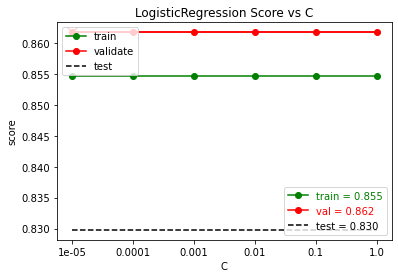

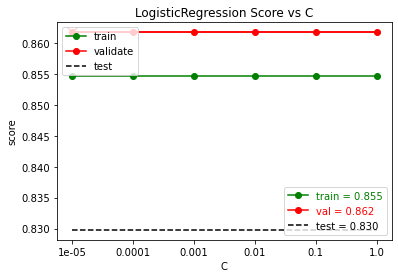

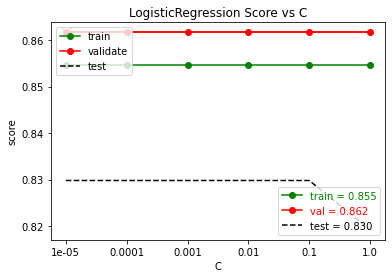

In [36]:
adjusted_parameter = 'C'
adjusted_parameter_values = [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0]

LogisticRegressionEstimators = train_estimators(drop_X_train, y_train,
                                                sklearn.linear_model.LogisticRegression,
                                                adjusted_parameter, adjusted_parameter_values,
                                                max_iter=10000,
                                                random_state=0)
plot_estimator_scores(LogisticRegressionEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        drop_X_train, y_train, drop_X_test, y_test, drop_X_val, y_val)


LogisticRegressionEstimators = train_estimators(OE_X_train, y_train,
                                                sklearn.linear_model.LogisticRegression,
                                                adjusted_parameter, adjusted_parameter_values,
                                                max_iter=10000,
                                                random_state=0)
plot_estimator_scores(LogisticRegressionEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OE_X_train, y_train, OE_X_test, y_test, OE_X_val, y_val)


LogisticRegressionEstimators = train_estimators(OH_X_train, y_train,
                                                sklearn.linear_model.LogisticRegression,
                                                adjusted_parameter, adjusted_parameter_values,
                                                max_iter=10000,
                                                random_state=0)
plot_estimator_scores(LogisticRegressionEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OH_X_train, y_train, OH_X_test, y_test, OH_X_val, y_val)

## SVM Classification

Training SVC(C=0.01, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=0.1, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=1.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=10.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=100.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=0.01, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=0.1, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=1.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=10.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=100.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=0.01, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=0.1, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=1.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=10.0, gamma=0.0001, max_iter=10000, random_state=0)...
Training SVC(C=100.0, ga

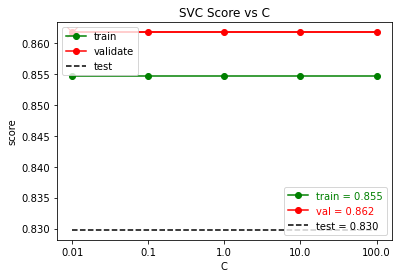

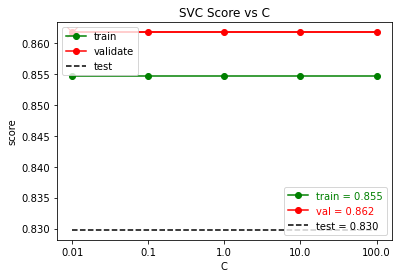

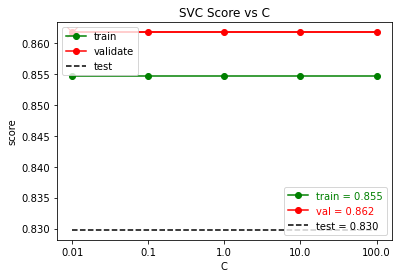

In [37]:
adjusted_parameter = 'C'
adjusted_parameter_values = [0.01, 0.1, 1.0, 10.0, 100.0]

SVMEstimators = train_estimators(drop_X_train, y_train,
                                    sklearn.svm.SVC,
                                    adjusted_parameter, adjusted_parameter_values,
                                    gamma=0.0001,
                                    max_iter=10000,
                                    random_state=0)
plot_estimator_scores(SVMEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        drop_X_train, y_train, drop_X_test, y_test, drop_X_val, y_val)


SVMEstimators = train_estimators(OE_X_train, y_train,
                                    sklearn.svm.SVC,
                                    adjusted_parameter, adjusted_parameter_values,
                                    gamma=0.0001,
                                    max_iter=10000,
                                    random_state=0)
plot_estimator_scores(SVMEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OE_X_train, y_train, OE_X_test, y_test, OE_X_val, y_val)


SVMEstimators = train_estimators(OH_X_train, y_train,
                                    sklearn.svm.SVC,
                                    adjusted_parameter, adjusted_parameter_values,
                                    gamma=0.0001,
                                    max_iter=10000,
                                    random_state=0)
plot_estimator_scores(SVMEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OH_X_train, y_train, OH_X_test, y_test, OH_X_val, y_val)

## Decision Tree Classification

Training DecisionTreeClassifier(max_depth=1, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=5, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=10, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=20, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=50, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=100, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=1, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=5, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=10, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=20, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=50, splitter='random', random_state=0)...
Training DecisionTreeClassifier(max_depth=100, splitter='random', random_state=

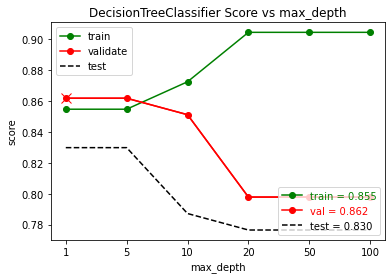

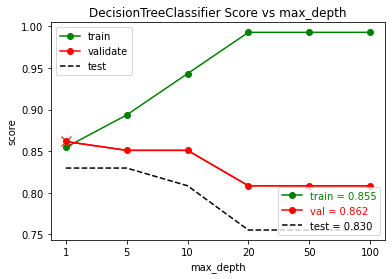

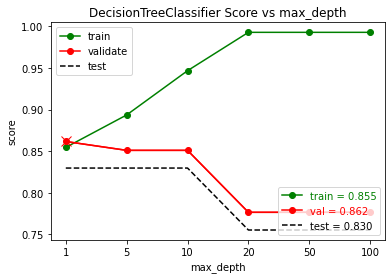

In [38]:
adjusted_parameter = 'max_depth'
adjusted_parameter_values = [1, 5, 10, 20, 50, 100]

DecisionTreeEstimators = train_estimators(drop_X_train, y_train,
                                            sklearn.tree.DecisionTreeClassifier,
                                            adjusted_parameter, adjusted_parameter_values,
                                            splitter='random',
                                            random_state=0)
plot_estimator_scores(DecisionTreeEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        drop_X_train, y_train, drop_X_test, y_test, drop_X_val, y_val)

DecisionTreeEstimators = train_estimators(OE_X_train, y_train,
                                            sklearn.tree.DecisionTreeClassifier,
                                            adjusted_parameter, adjusted_parameter_values,
                                            splitter='random',
                                            random_state=0)
plot_estimator_scores(DecisionTreeEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OE_X_train, y_train, OE_X_test, y_test, OE_X_val, y_val)


DecisionTreeEstimators = train_estimators(OH_X_train, y_train,
                                            sklearn.tree.DecisionTreeClassifier,
                                            adjusted_parameter, adjusted_parameter_values,
                                            splitter='random',
                                            random_state=0)
plot_estimator_scores(DecisionTreeEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OH_X_train, y_train, OH_X_test, y_test, OH_X_val, y_val)

## RandomForest Classification

Training RandomForestClassifier(max_depth=1, random_state=0)...
Training RandomForestClassifier(max_depth=5, random_state=0)...
Training RandomForestClassifier(max_depth=10, random_state=0)...
Training RandomForestClassifier(max_depth=20, random_state=0)...
Training RandomForestClassifier(max_depth=50, random_state=0)...
Training RandomForestClassifier(max_depth=100, random_state=0)...
Training RandomForestClassifier(max_depth=1, random_state=0)...
Training RandomForestClassifier(max_depth=5, random_state=0)...
Training RandomForestClassifier(max_depth=10, random_state=0)...
Training RandomForestClassifier(max_depth=20, random_state=0)...
Training RandomForestClassifier(max_depth=50, random_state=0)...
Training RandomForestClassifier(max_depth=100, random_state=0)...
Training RandomForestClassifier(max_depth=1, random_state=0)...
Training RandomForestClassifier(max_depth=5, random_state=0)...
Training RandomForestClassifier(max_depth=10, random_state=0)...
Training RandomForestClassifi

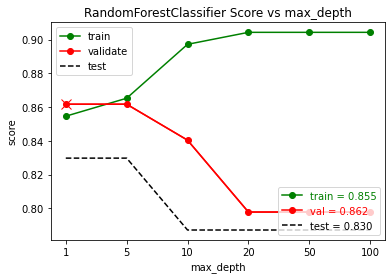

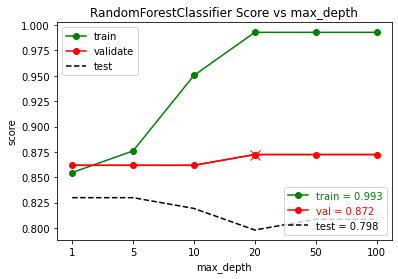

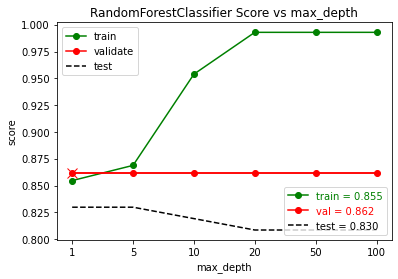

In [39]:
adjusted_parameter = 'max_depth'
adjusted_parameter_values = [1, 5, 10, 20, 50, 100]

RandomTreeEstimators = train_estimators(drop_X_train, y_train,
                                        sklearn.ensemble.RandomForestClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        random_state=0)
plot_estimator_scores(RandomTreeEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        drop_X_train, y_train, drop_X_test, y_test, drop_X_val, y_val)


RandomTreeEstimators = train_estimators(OE_X_train, y_train,
                                        sklearn.ensemble.RandomForestClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        random_state=0)
plot_estimator_scores(RandomTreeEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OE_X_train, y_train, OE_X_test, y_test, OE_X_val, y_val)


RandomTreeEstimators = train_estimators(OH_X_train, y_train,
                                        sklearn.ensemble.RandomForestClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        random_state=0)
plot_estimator_scores(RandomTreeEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OH_X_train, y_train, OH_X_test, y_test, OH_X_val, y_val)

## K-nearest Classification

Training KNeighborsClassifier(weights=uniform, n_neighbors=2)...
Training KNeighborsClassifier(weights=distance, n_neighbors=2)...
Training KNeighborsClassifier(weights=uniform, n_neighbors=2)...
Training KNeighborsClassifier(weights=distance, n_neighbors=2)...
Training KNeighborsClassifier(weights=uniform, n_neighbors=2)...
Training KNeighborsClassifier(weights=distance, n_neighbors=2)...


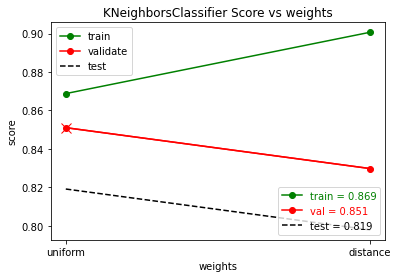

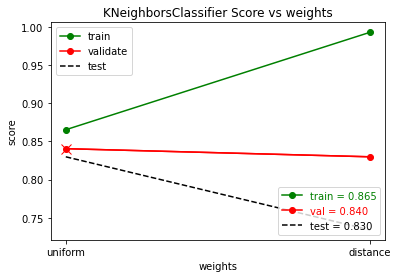

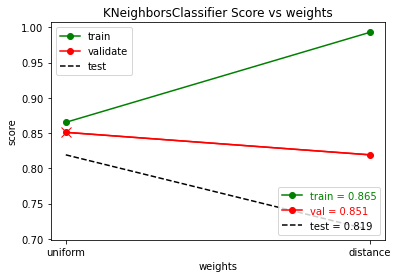

In [40]:
adjusted_parameter = 'weights'
adjusted_parameter_values = ['uniform','distance']

KNearestEstimators = train_estimators(drop_X_train, y_train,
                                        sklearn.neighbors.KNeighborsClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        n_neighbors=2)
plot_estimator_scores(KNearestEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        drop_X_train, y_train, drop_X_test, y_test, drop_X_val, y_val)


KNearestEstimators = train_estimators(OE_X_train, y_train,
                                        sklearn.neighbors.KNeighborsClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        n_neighbors=2)
plot_estimator_scores(KNearestEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OE_X_train, y_train, OE_X_test, y_test, OE_X_val, y_val)


KNearestEstimators = train_estimators(OH_X_train, y_train,
                                        sklearn.neighbors.KNeighborsClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        n_neighbors=2)
plot_estimator_scores(KNearestEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OH_X_train, y_train, OH_X_test, y_test, OH_X_val, y_val)

Training KNeighborsClassifier(algorithm=auto, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=ball_tree, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=kd_tree, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=brute, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=auto, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=ball_tree, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=kd_tree, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=brute, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=auto, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=ball_tree, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=kd_tree, n_neighbors=2)...
Training KNeighborsClassifier(algorithm=brute, n_neighbors=2)...


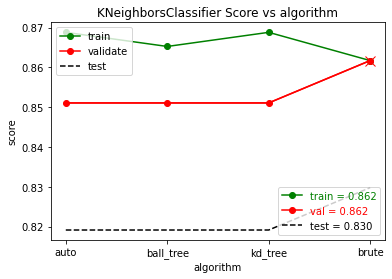

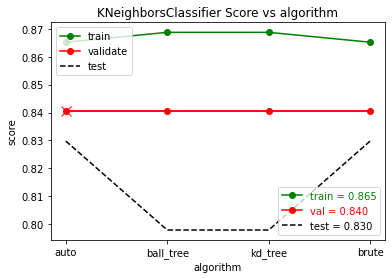

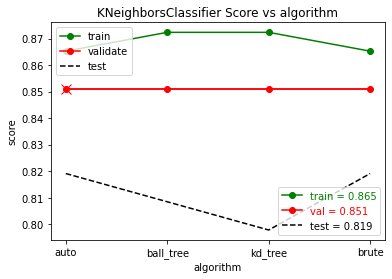

In [41]:
adjusted_parameter = 'algorithm'
adjusted_parameter_values = ['auto', 'ball_tree', 'kd_tree','brute']

KNearestEstimators = train_estimators(drop_X_train, y_train,
                                        sklearn.neighbors.KNeighborsClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        n_neighbors=2)
plot_estimator_scores(KNearestEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        drop_X_train, y_train, drop_X_test, y_test, drop_X_val, y_val)


KNearestEstimators = train_estimators(OE_X_train, y_train,
                                        sklearn.neighbors.KNeighborsClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        n_neighbors=2)
plot_estimator_scores(KNearestEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OE_X_train, y_train, OE_X_test, y_test, OE_X_val, y_val)


KNearestEstimators = train_estimators(OH_X_train, y_train,
                                        sklearn.neighbors.KNeighborsClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        n_neighbors=2)
plot_estimator_scores(KNearestEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OH_X_train, y_train, OH_X_test, y_test, OH_X_val, y_val)

## Ada Boost Classification

Training AdaBoostClassifier(n_estimators=10, random_state=0)...
Training AdaBoostClassifier(n_estimators=50, random_state=0)...
Training AdaBoostClassifier(n_estimators=100, random_state=0)...
Training AdaBoostClassifier(n_estimators=500, random_state=0)...
Training AdaBoostClassifier(n_estimators=1000, random_state=0)...
Training AdaBoostClassifier(n_estimators=5000, random_state=0)...
Training AdaBoostClassifier(n_estimators=10, random_state=0)...
Training AdaBoostClassifier(n_estimators=50, random_state=0)...
Training AdaBoostClassifier(n_estimators=100, random_state=0)...
Training AdaBoostClassifier(n_estimators=500, random_state=0)...
Training AdaBoostClassifier(n_estimators=1000, random_state=0)...
Training AdaBoostClassifier(n_estimators=5000, random_state=0)...
Training AdaBoostClassifier(n_estimators=10, random_state=0)...
Training AdaBoostClassifier(n_estimators=50, random_state=0)...
Training AdaBoostClassifier(n_estimators=100, random_state=0)...
Training AdaBoostClassifier

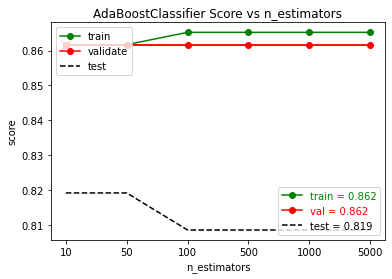

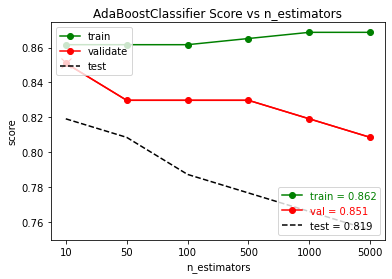

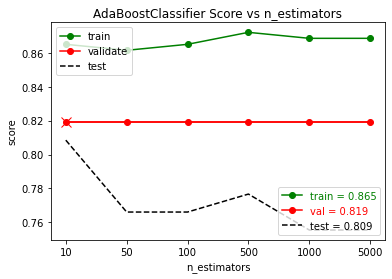

In [42]:
adjusted_parameter = 'n_estimators'
adjusted_parameter_values = [10, 50, 100, 500, 1000, 5000]

AdaBoostEstimators = train_estimators(drop_X_train, y_train,
                                        sklearn.ensemble.AdaBoostClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        random_state=0)
plot_estimator_scores(AdaBoostEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        drop_X_train, y_train, drop_X_test, y_test, drop_X_val, y_val)


AdaBoostEstimators = train_estimators(OE_X_train, y_train,
                                        sklearn.ensemble.AdaBoostClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        random_state=0)
plot_estimator_scores(AdaBoostEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OE_X_train, y_train, OE_X_test, y_test, OE_X_val, y_val)


AdaBoostEstimators = train_estimators(OH_X_train, y_train,
                                        sklearn.ensemble.AdaBoostClassifier,
                                        adjusted_parameter, adjusted_parameter_values,
                                        random_state=0)
plot_estimator_scores(AdaBoostEstimators,
                        adjusted_parameter, adjusted_parameter_values,
                        OH_X_train, y_train, OH_X_test, y_test, OH_X_val, y_val)

## Gaussian Naive Bayes Classification

In [43]:
drop_gaussian_nb = sklearn.naive_bayes.GaussianNB()
NaiveBayesEstimator = drop_gaussian_nb.fit(drop_X_train, y_train)
gaussian_nb_train_score = NaiveBayesEstimator.score(drop_X_train, y_train)
gaussian_nb_test_score =  NaiveBayesEstimator.score(drop_X_test, y_test)
gaussian_nb_val_score =  NaiveBayesEstimator.score(drop_X_val, y_val)
print(f'{gaussian_nb_train_score=}, {gaussian_nb_val_score=}, {gaussian_nb_test_score=}')

OE_gaussian_nb = sklearn.naive_bayes.GaussianNB()
NaiveBayesEstimator = OE_gaussian_nb.fit(OE_X_train, y_train)
gaussian_nb_train_score = NaiveBayesEstimator.score(OE_X_train, y_train)
gaussian_nb_test_score =  NaiveBayesEstimator.score(OE_X_test, y_test)
gaussian_nb_val_score =  NaiveBayesEstimator.score(OE_X_val, y_val)
print(f'{gaussian_nb_train_score=}, {gaussian_nb_val_score=}, {gaussian_nb_test_score=}')

OH_gaussian_nb = sklearn.naive_bayes.GaussianNB()
NaiveBayesEstimator = OH_gaussian_nb.fit(OH_X_train, y_train)
gaussian_nb_train_score = NaiveBayesEstimator.score(OH_X_train, y_train)
gaussian_nb_test_score =  NaiveBayesEstimator.score(OH_X_test, y_test)
gaussian_nb_val_score =  NaiveBayesEstimator.score(OH_X_val, y_val)
print(f'{gaussian_nb_train_score=}, {gaussian_nb_val_score=}, {gaussian_nb_test_score=}')

gaussian_nb_train_score=0.32978723404255317, gaussian_nb_val_score=0.26595744680851063, gaussian_nb_test_score=0.3723404255319149
gaussian_nb_train_score=0.20212765957446807, gaussian_nb_val_score=0.19148936170212766, gaussian_nb_test_score=0.1702127659574468
gaussian_nb_train_score=0.2127659574468085, gaussian_nb_val_score=0.20212765957446807, gaussian_nb_test_score=0.1702127659574468
